In [1]:
EPTA_dir='EPTA_J1713/'
EINPTA_dir='EPTA+INPTA_J1713/'

In [2]:
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'../..')))
from getdist import plots, MCSamples
from getdist.gaussian_mixtures import GaussianND
import getdist
getdist.chains.print_load_details = False
import scipy
import matplotlib.pyplot as plt
import IPython
from IPython.display import Markdown
import numpy as np
import seaborn as sns
# import the tensiometer tools that we need:
import tensiometer
from tensiometer import utilities
from tensiometer import gaussian_tension
from tensiometer import mcmc_tension


2023-03-13 16:53:28.335234: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-13 16:53:28.362689: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-13 16:53:28.363308: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 16:53:28.846220: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [8]:
epta_1=np.loadtxt(EPTA_dir+'chain_1.txt')
par_epta=np.loadtxt(EPTA_dir+'pars.txt',dtype=str)
len_epta=len(par_epta)
epta_2=epta_1.T

In [9]:
einpta_1=np.loadtxt(EINPTA_dir+'chain_1.txt')
par_einpta=np.loadtxt(EINPTA_dir+'pars.txt',dtype=str)
len_einpta=len(par_einpta)
einpta_2=einpta_1.T

In [10]:
epta_arr=[epta_2[len(par_epta)-1],epta_2[len(par_epta)-2],epta_2[len(par_epta)-9],epta_2[len(par_epta)-10]]

einpta_arr=[einpta_2[len(par_einpta)-1],einpta_2[len(par_einpta)-2],einpta_2[len(par_einpta)-9],einpta_2[len(par_einpta)-10]]

In [11]:
names = ['rn_logA','rn_gamma','dm_logA','dm_gamma']
labels=['\log A_R','\gamma_R', '\log A_{DM}','\gamma_{DM}']
del_names=['delta_logA','delta_gamma']

In [12]:
epta=MCSamples(samples=np.array(epta_arr).transpose(),loglikes=epta_2[-3],names=names,labels=labels,label='EPTA')
einpta=MCSamples(samples=np.array(einpta_arr).transpose(),loglikes=einpta_2[-3],names = names,labels=labels,label='EPTA+INPTA')

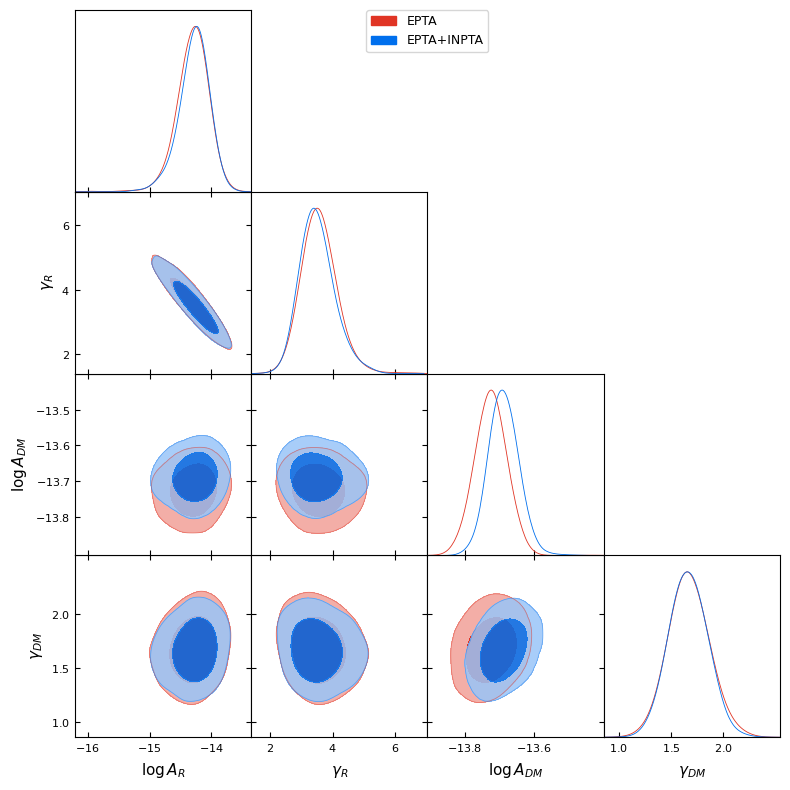

In [20]:
g = plots.get_subplot_plotter()
g.triangle_plot([epta,einpta], filled=True)

In [14]:
input_arr=[epta,einpta]

In [15]:
for i,chain in enumerate(input_arr):
        chain.chain_offsets =np.linspace(0,len(input_arr[i].samples[:,0]),10,dtype = int)

In [16]:
diff_chain = mcmc_tension.parameter_diff_chain(epta,einpta, boost=4)

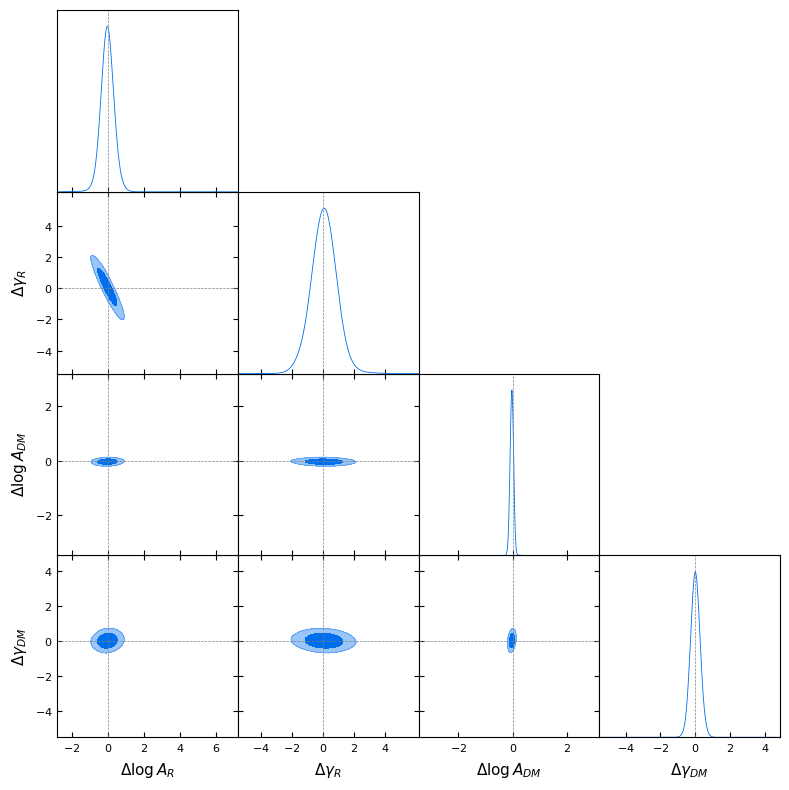

In [22]:
g = plots.get_subplot_plotter()
g.triangle_plot(diff_chain, filled=True,markers=[0,0,0,0])
plt.savefig('abc.png',dpi=300)

In [18]:
diff_flow_callback = tensiometer.mcmc_tension.DiffFlowCallback(diff_chain, feedback=1, learning_rate=0.01)

2023-03-13 16:59:33.466938: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-03-13 16:59:33.467320: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Building training/test samples
    - 2398803/266533 training/test samples and uniform weights.
Building MAF
    - number of MAFs: 8
    - activation: <function asinh at 0x7fc820fd4ca0>
    - hidden_units: [8, 8]
Building flow
    - trainable parameters: 1472


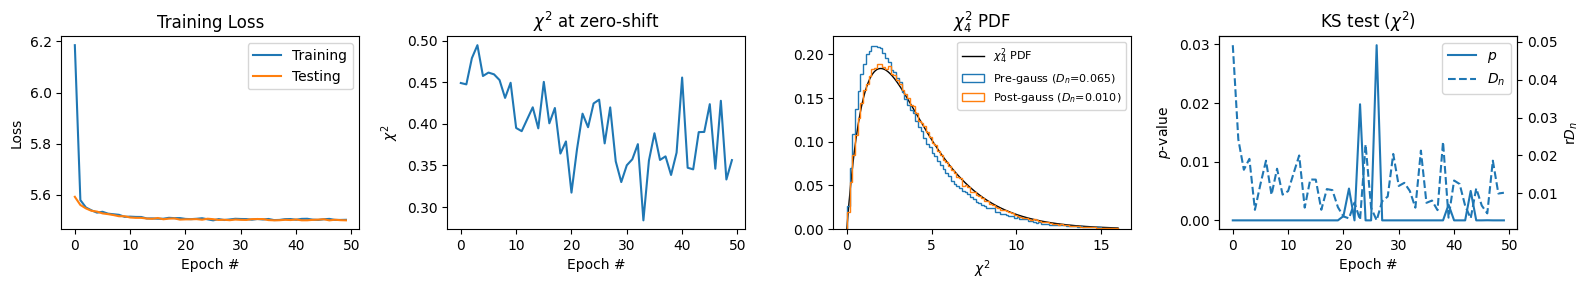

64/64 [==============================] - 2s 37ms/step - loss: 5.5021 - val_loss: 5.4999 - shift0_chi2: 0.3565 - shift0_pval: 0.0141 - shift0_nsigma: 0.0177 - chi2Z_ks: 0.0101 - chi2Z_ks_p: 4.1158e-24 - lr: 0.0100


In [19]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
callbacks = [ReduceLROnPlateau()]

batch_size = 8192
epochs = 50
steps_per_epoch = 64

diff_flow_callback.train(batch_size=batch_size, epochs=epochs, steps_per_epoch=steps_per_epoch, callbacks=callbacks)

In [23]:
exact_shift_P_1, exact_shift_low_1, exact_shift_hi_1 = diff_flow_callback.estimate_shift()
print(f'Shift probability considering all parameters = {exact_shift_P_1:.5f} +{exact_shift_hi_1-exact_shift_P_1:.5f} -{exact_shift_P_1-exact_shift_low_1:.5f}')
# turn the result to effective number of sigmas:
print(f'    n_sigma = {utilities.from_confidence_to_sigma(exact_shift_P_1):.3f}')


Shift probability considering all parameters = 0.00942 +0.00031 -0.00030
    n_sigma = 0.012
